In [5]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
from itertools import product

# ECEC File paths

ecec_files = {
    "2022": "https://raw.githubusercontent.com/duehl85/econ8310_semester_project/main/CSIData/ECEC%202022%20Student%20Sign%20In%20and%20Out.xlsx",
    "2023": "https://raw.githubusercontent.com/duehl85/econ8310_semester_project/main/CSIData/ECEC%202023%20Student%20Sign%20In%20and%20Out.xlsx",
    "2024": "https://raw.githubusercontent.com/duehl85/econ8310_semester_project/main/CSIData/ECEC%202024%20Student%20Sign%20In%20and%20Out.xlsx",
    "2025": "https://raw.githubusercontent.com/duehl85/econ8310_semester_project/main/CSIData/ECEC%202025%2001012025-02282025%20Student%20Sign%20In%20and%20Out.xlsx"
}

#Spellman File Paths

spellman_files = {
    "2022": "https://raw.githubusercontent.com/duehl85/econ8310_semester_project/main/CSIData/Spellman%20CDC%202022%20Student%20Sign%20in%20and%20out.xlsx",
    "2023": "https://raw.githubusercontent.com/duehl85/econ8310_semester_project/main/CSIData/Spellman%20CDC%202023%20Student%20Sign%20in%20and%20out.xlsx",
    "2024": "https://raw.githubusercontent.com/duehl85/econ8310_semester_project/main/CSIData/Spellman%20CDC%202024%20Student%20Sign%20in%20and%20out.xlsx",
    "2025": "https://raw.githubusercontent.com/duehl85/econ8310_semester_project/main/CSIData/Spellman%20CDC%202025%2001012025-02282025%20Student%20Sign%20in%20and%20out.xlsx"
}

# Age group dictionary for spellman

spellman_age_dict = {
    "Good Night Moon": "Infants",
    "Panda Bear": "Toddlers",
    "House of Pooh": "Infants",
    "Llama Llama": "Multi-Age",
    "Caterpillars": "Multi-Age",
    "Rabbits": "Toddlers",
    "Wild Things": "Preschool",
    "Monkeys": "Toddlers",
    "Rainbow Fish": "Preschool",
    "Dinosaurs": "Pre-K"
}

# Create function to load and clean the files

def load_and_clean_file(file_path, year, age_group_func):
    df_raw = pd.read_excel(file_path, header=[0, 1], skiprows=5)
    meta_df = df_raw.iloc[:, :7].copy()
    timestamps_df = df_raw.iloc[:, 7:].copy()

    meta_df.columns = ['_'.join([str(x) for x in c if 'Unnamed' not in str(x)]).strip() for c in meta_df.columns]
    timestamps_df.columns = [f"{str(c[0]).strip()}_{str(c[1]).strip()}" for c in timestamps_df.columns]

    meta_df['row_id'] = meta_df.index
    timestamps_df['row_id'] = timestamps_df.index

    long_df = timestamps_df.melt(id_vars='row_id', var_name='date_inout', value_name='timestamp')
    long_df[['date_str', 'in_out']] = long_df['date_inout'].str.extract(r'(.*)_(IN|OUT)', expand=True)
    long_df['date_str'] = long_df['date_str'].str.strip() + f' {year}'
    long_df['date'] = pd.to_datetime(long_df['date_str'], format='%b %d %Y', errors='coerce')

    pivot_df = long_df.pivot_table(index=['row_id', 'date'], columns='in_out', values='timestamp', aggfunc='first').reset_index()
    for col in ['IN', 'OUT']:
        if col not in pivot_df.columns:
            pivot_df[col] = pd.NaT

    final_df = pivot_df.merge(meta_df, on='row_id', how='left')

    def clean_time_only(x):
        if pd.isna(x):
            return x
        match = re.match(r'^\s*\d{1,2}:\d{2}\s*(AM|PM)', str(x), re.IGNORECASE)
        return match.group(0) if match else x

    final_df['IN'] = final_df['IN'].apply(clean_time_only)
    final_df['OUT'] = final_df['OUT'].apply(clean_time_only)
    final_df['year'] = int(year)
    final_df['OUT'] = final_df['OUT'].replace('--', pd.NA)

    final_df['in_datetime'] = pd.to_datetime(final_df['date'].astype(str) + ' ' + final_df['IN'], errors='coerce')
    final_df['out_datetime'] = pd.to_datetime(final_df['date'].astype(str) + ' ' + final_df['OUT'], errors='coerce')

    final_df['age_group'] = final_df['Room'].apply(age_group_func)

    return final_df[['Record ID', 'Student Status', 'Room', 'Tags', 'date', 'in_datetime', 'out_datetime', 'year', 'age_group']]

# Load and combine both datasets

ecec_age_func = lambda room: re.search(r'(Infants|Multi-Age|Toddlers|Preschool|Pre-K)', str(room)).group(0) if re.search(r'(Infants|Multi-Age|Toddlers|Preschool|Pre-K)', str(room)) else None
spellman_age_func = lambda room: spellman_age_dict.get(str(room).strip())

ecec_df = pd.concat(
    [load_and_clean_file(path, year, ecec_age_func) for year, path in ecec_files.items()],
    ignore_index=True
)

spellman_df = pd.concat(
    [load_and_clean_file(path, year, spellman_age_func) for year, path in spellman_files.items()],
    ignore_index=True
)

all_years_df = pd.concat([ecec_df, spellman_df], ignore_index=True)
all_years_df = all_years_df.dropna(subset=['in_datetime', 'out_datetime'])


# Filter to only include active students

all_years_df = all_years_df[all_years_df['Student Status'].str.lower() == 'active']

# Generate 30-min blocks per student

def generate_30min_blocks(start, end):
    return pd.date_range(start=start, end=end, freq='30min').tolist()

all_years_df['time_blocks'] = all_years_df.apply(lambda row: generate_30min_blocks(row['in_datetime'], row['out_datetime']), axis=1)
expanded_df = all_years_df.explode('time_blocks')
expanded_df['time_block'] = expanded_df['time_blocks'].dt.floor('30min')

attendance_grid = expanded_df[['Record ID', 'Student Status', 'age_group', 'time_block']].copy()


# Group and calculate children per block

grouped = attendance_grid.groupby(['age_group', 'time_block', 'Student Status']).agg(
    children_present=('Record ID', 'nunique')
).reset_index()


# Merge staffing ratios

ratio_table = pd.DataFrame({
    'age_group': ['Infants', 'Multi-Age', 'Toddlers', 'Preschool', 'Pre-K'],
    'student_to_staff': [4, 4, 6, 10, 12]
})

grouped = grouped.merge(ratio_table, on='age_group', how='left')
grouped['staff_required'] = np.ceil(grouped['children_present'] / grouped['student_to_staff']).astype(int)


# Build complete time block grid to fill 0s for off time (weekends/evenings)

full_time_index = pd.date_range(
    start="2022-01-01 00:00:00",
    end="2025-02-28 23:30:00",
    freq="30min"
)

all_age_groups = grouped['age_group'].dropna().unique()
all_statuses = grouped['Student Status'].dropna().unique()

full_index = pd.DataFrame(
    list(product(all_age_groups, full_time_index, all_statuses)),
    columns=['age_group', 'time_block', 'Student Status']
)

grouped_full = full_index.merge(grouped, on=['age_group', 'time_block', 'Student Status'], how='left')
grouped_full['children_present'] = grouped_full['children_present'].fillna(0).astype(int)
grouped_full['student_to_staff'] = grouped_full['student_to_staff'].fillna(
    grouped_full['age_group'].map(ratio_table.set_index('age_group')['student_to_staff'])
)
grouped_full['staff_required'] = np.ceil(grouped_full['children_present'] / grouped_full['student_to_staff']).fillna(0).astype(int)



<ipython-input-5-6ab6c63e7e15>:77: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  final_df['out_datetime'] = pd.to_datetime(final_df['date'].astype(str) + ' ' + final_df['OUT'], errors='coerce')
<ipython-input-5-6ab6c63e7e15>:77: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  final_df['out_datetime'] = pd.to_datetime(final_df['date'].astype(str) + ' ' + final_df['OUT'], errors='coerce')
<ipython-input-5-6ab6c63e7e15>:77: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  final_df['out_datetime'] = pd.to_datetime(final_df['date'].astype(str) + ' ' + final_df['OUT'], errors='coerce'

Test RMSE: 0.00


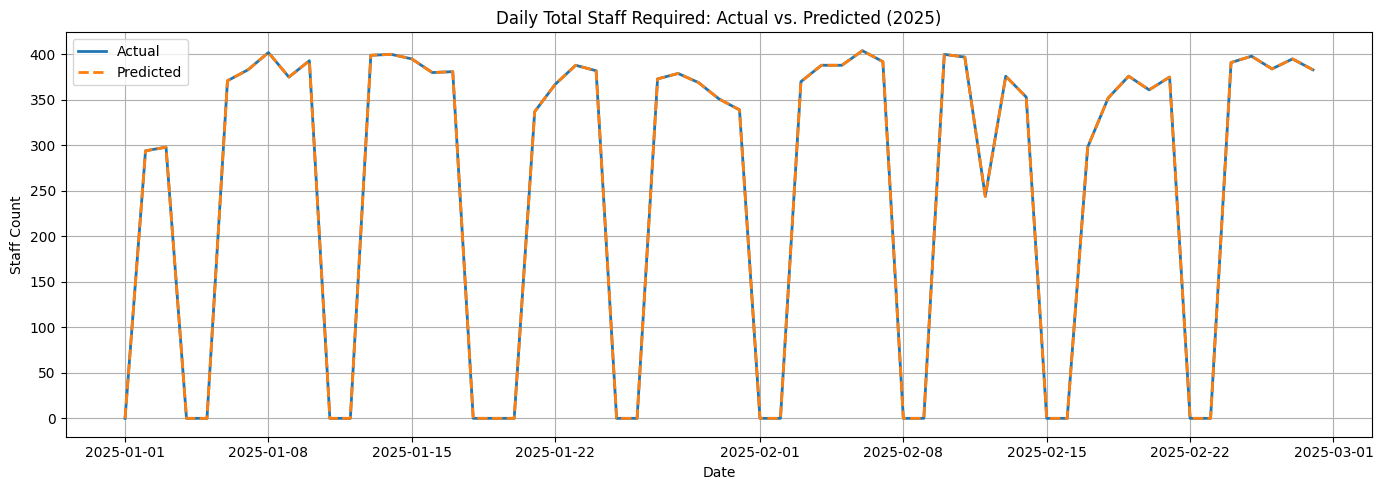

In [6]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


# Convert timestamp to prepare for XGBooost

df = grouped_full.copy()

df['hour'] = df['time_block'].dt.hour
df['minute'] = df['time_block'].dt.minute
df['half_hour_index'] = df['hour'] * 2 + (df['minute'] // 30)
df['dayofweek'] = df['time_block'].dt.dayofweek
df['weekofyear'] = df['time_block'].dt.isocalendar().week
df['month'] = df['time_block'].dt.month
df['year'] = df['time_block'].dt.year

#Convert age_group and Student Status into dummy variables to prepare for XGBoost
df_model = pd.get_dummies(df, columns=['age_group', 'Student Status'], drop_first=True)


# Train using 2024 data and use 2025 for predictions

train_df = df_model[df_model['year'] < 2025]
test_df = df_model[(df_model['year'] == 2025) & (df_model['time_block'].dt.month <= 2)]

# Define feature columns (drop time_block and target)
feature_cols = [col for col in train_df.columns if col not in ['time_block', 'staff_required']]

X_train = train_df[feature_cols]
y_train = train_df['staff_required']
X_test = test_df[feature_cols]
y_test = test_df['staff_required']


# Train XGBoost regressor model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train, y_train)

#make predictions, round predictions to next whole number, and calculate error

y_pred = model.predict(X_test)
y_pred_rounded = np.round(y_pred).astype(int)
mse = mean_squared_error(y_test, y_pred_rounded)
rmse = np.sqrt(mse)
print(f"Test RMSE: {rmse:.2f}")


# Visualize

test_df = test_df.copy()
test_df['predicted_staff'] = y_pred_rounded

# Plot total staff required per day (actual vs predicted)
staff_by_day = test_df.copy()
staff_by_day['date'] = staff_by_day['time_block'].dt.date

daily_actual = staff_by_day.groupby('date')['staff_required'].sum()
daily_pred = staff_by_day.groupby('date')['predicted_staff'].sum()

plt.figure(figsize=(14, 5))
plt.plot(daily_actual.index, daily_actual, label='Actual', linewidth=2)
plt.plot(daily_pred.index, daily_pred, label='Predicted', linewidth=2, linestyle='--')
plt.title('Daily Total Staff Required: Actual vs. Predicted (2025)')
plt.ylabel('Staff Count')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# Round predictions to nearest integer
test_df['predicted_staff_rounded'] = test_df['predicted_staff'].astype(int)

# Compare predicted vs actual
correct_preds = (test_df['predicted_staff_rounded'] == test_df['staff_required'])

# Calculate accuracy
accuracy = correct_preds.mean()

print(f"Accuracy Score: {accuracy:.2%}")

Accuracy Score: 100.00%


In [8]:
# Compute average staffing needs per time block for each weekday
typical_week_forecast = df_model.groupby(['dayofweek', 'half_hour_index'])['staff_required'].mean().reset_index()

# Convert half-hour index back to hours/minutes
typical_week_forecast['hour'] = typical_week_forecast['half_hour_index'] // 2
typical_week_forecast['minute'] = (typical_week_forecast['half_hour_index'] % 2) * 30

print(typical_week_forecast.head())  # Check typical weekly forecast trends

   dayofweek  half_hour_index  staff_required  hour  minute
0          0                0             0.0     0       0
1          0                1             0.0     0      30
2          0                2             0.0     1       0
3          0                3             0.0     1      30
4          0                4             0.0     2       0


In [9]:
# Get last recorded date
last_date = df_model['time_block'].max()
next_week_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=7*48, freq="30min")

# Prepare new features for prediction
next_week_df = pd.DataFrame({'time_block': next_week_dates})
next_week_df['dayofweek'] = next_week_df['time_block'].dt.dayofweek
next_week_df['half_hour_index'] = next_week_df['time_block'].dt.hour * 2 + (next_week_df['time_block'].dt.minute // 30)

# Merge with historical weekly patterns (ensuring time structure remains consistent)
next_week_df = next_week_df.merge(typical_week_forecast, on=['dayofweek', 'half_hour_index'], how='left')
next_week_df['staff_required'] = np.round(next_week_df['staff_required']).astype(int)

print(next_week_df.head())  # View predictions for next week

           time_block  dayofweek  half_hour_index  staff_required  hour  \
0 2025-03-01 23:30:00          5               47               0    23   
1 2025-03-02 00:00:00          6                0               0     0   
2 2025-03-02 00:30:00          6                1               0     0   
3 2025-03-02 01:00:00          6                2               0     1   
4 2025-03-02 01:30:00          6                3               0     1   

   minute  
0      30  
1       0  
2      30  
3       0  
4      30  


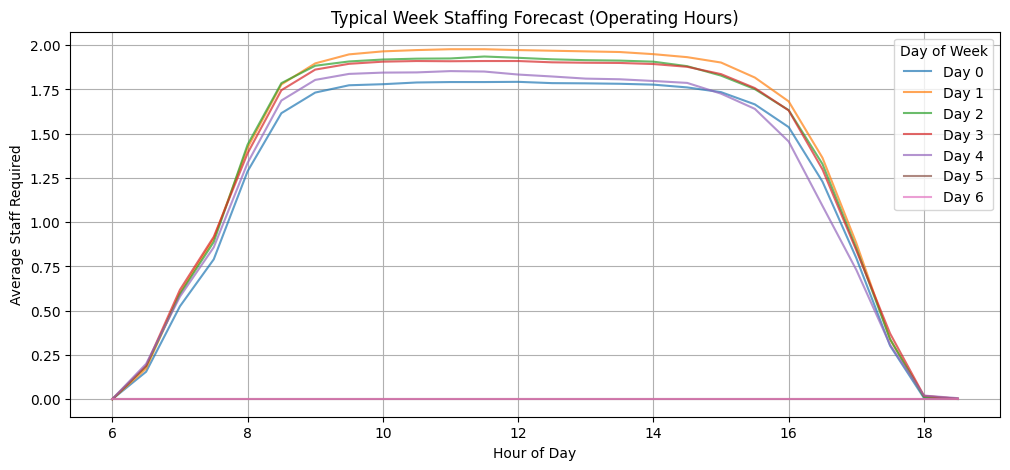

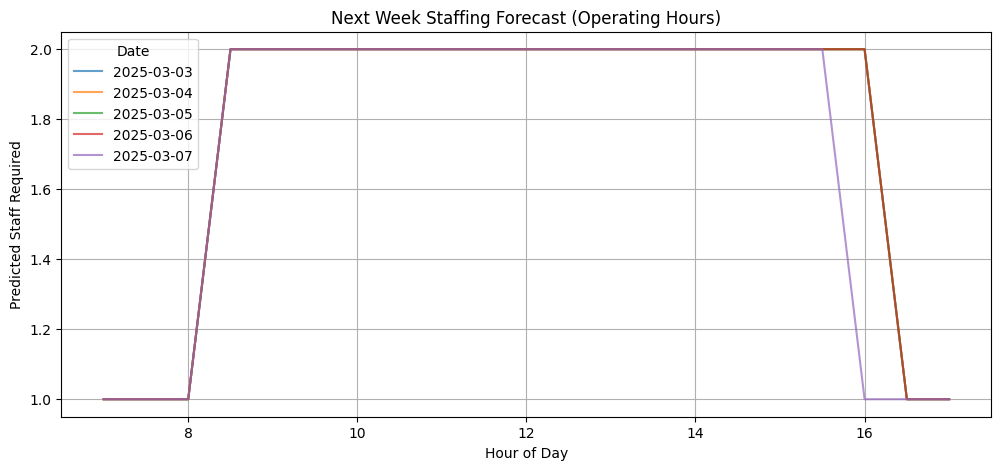

In [11]:
import matplotlib.pyplot as plt

# Define operating hours (e.g., 6 AM to 6 PM)
OPERATING_HOURS = (6, 18)

# Filter data to only include operating hours
typical_week_filtered = typical_week_forecast[
    (typical_week_forecast['hour'] >= OPERATING_HOURS[0]) &
    (typical_week_forecast['hour'] <= OPERATING_HOURS[1])
]

next_week_filtered = next_week_df[
    (next_week_df['time_block'].dt.hour >= OPERATING_HOURS[0]) &
    (next_week_df['time_block'].dt.hour <= OPERATING_HOURS[1]) &
    (next_week_df['staff_required'] > 0)  # Only show nonzero staff requirements
]

# Plot Typical Week Forecast
plt.figure(figsize=(12, 5))
for day in range(7):  # Loop through Monday-Sunday
    subset = typical_week_filtered[typical_week_filtered['dayofweek'] == day]
    plt.plot(subset['hour'] + subset['minute']/60, subset['staff_required'], label=f'Day {day}', alpha=0.7)

plt.title("Typical Week Staffing Forecast (Operating Hours)")
plt.xlabel("Hour of Day")
plt.ylabel("Average Staff Required")
plt.legend(title="Day of Week")
plt.grid(True)
plt.show()

# Plot Next Week Forecast
plt.figure(figsize=(12, 5))
for date in next_week_filtered['time_block'].dt.date.unique():
    subset = next_week_filtered[next_week_filtered['time_block'].dt.date == date]
    plt.plot(subset['time_block'].dt.hour + subset['time_block'].dt.minute / 60, subset['staff_required'], label=str(date), alpha=0.7)

plt.title("Next Week Staffing Forecast (Operating Hours)")
plt.xlabel("Hour of Day")
plt.ylabel("Predicted Staff Required")
plt.legend(title="Date")
plt.grid(True)
plt.show()

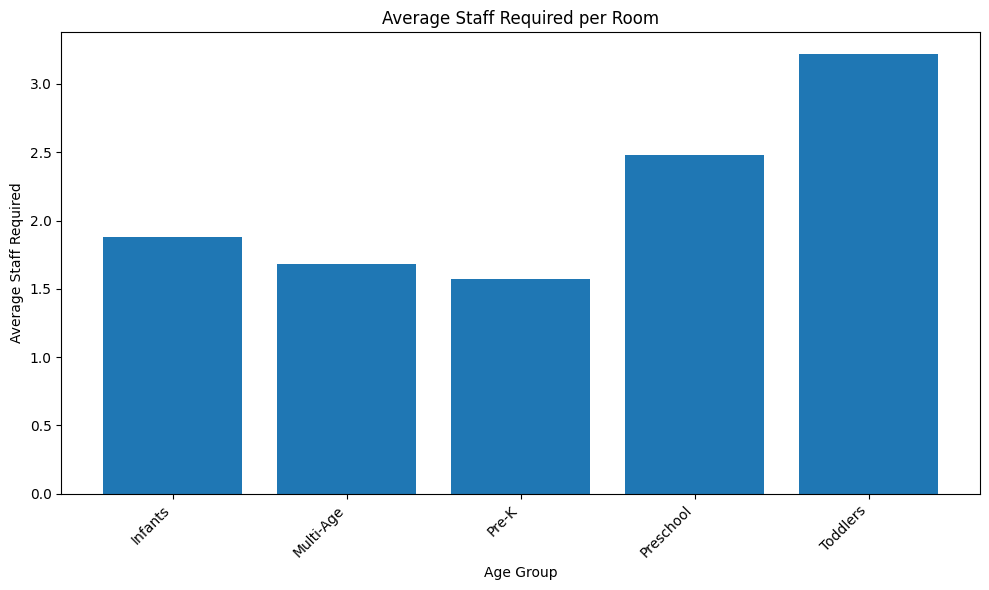

In [12]:
import matplotlib.pyplot as plt

# Calculate average staff required per room
average_staff_per_room = grouped.groupby('age_group')['staff_required'].mean().reset_index()

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(average_staff_per_room['age_group'], average_staff_per_room['staff_required'])
plt.xlabel('Age Group')
plt.ylabel('Average Staff Required')
plt.title('Average Staff Required per Room')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


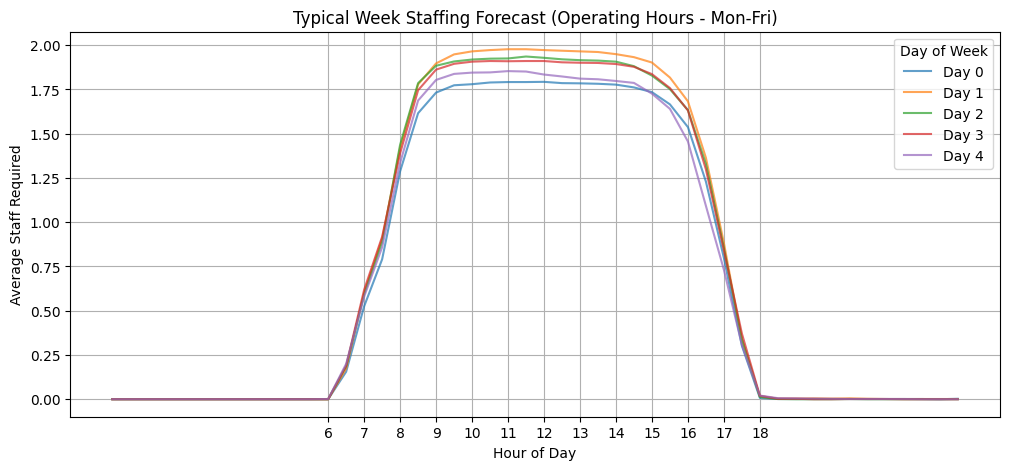

In [13]:

# Exclude days 5 and 6 (Saturday and Sunday)
typical_week_forecast_filtered = typical_week_forecast[~typical_week_forecast['dayofweek'].isin([5, 6])]
grouped['staff_required'] = np.ceil(grouped['children_present'] / grouped['student_to_staff']).astype(int)


# Plot Typical Week Forecast (excluding Saturday and Sunday)
plt.figure(figsize=(12, 5))
for day in range(5):  # Loop through Monday-Friday
    subset = typical_week_forecast_filtered[typical_week_forecast_filtered['dayofweek'] == day]
    plt.plot(subset['hour'] + subset['minute'] / 60, subset['staff_required'], label=f'Day {day}', alpha=0.7)

plt.title("Typical Week Staffing Forecast (Operating Hours - Mon-Fri)")
plt.xlabel("Hour of Day")
plt.ylabel("Average Staff Required")
plt.legend(title="Day of Week")
plt.grid(True)
plt.xticks(np.arange(OPERATING_HOURS[0], OPERATING_HOURS[1] + 1, 1))

plt.show()



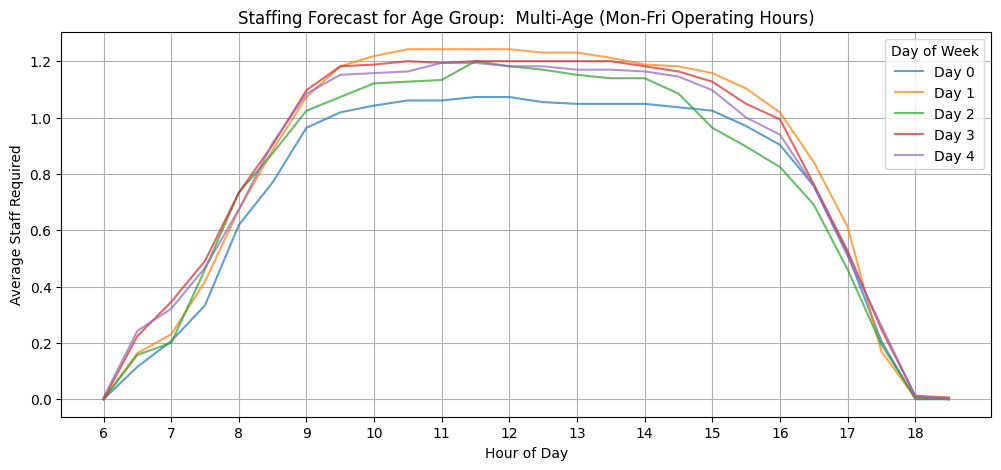

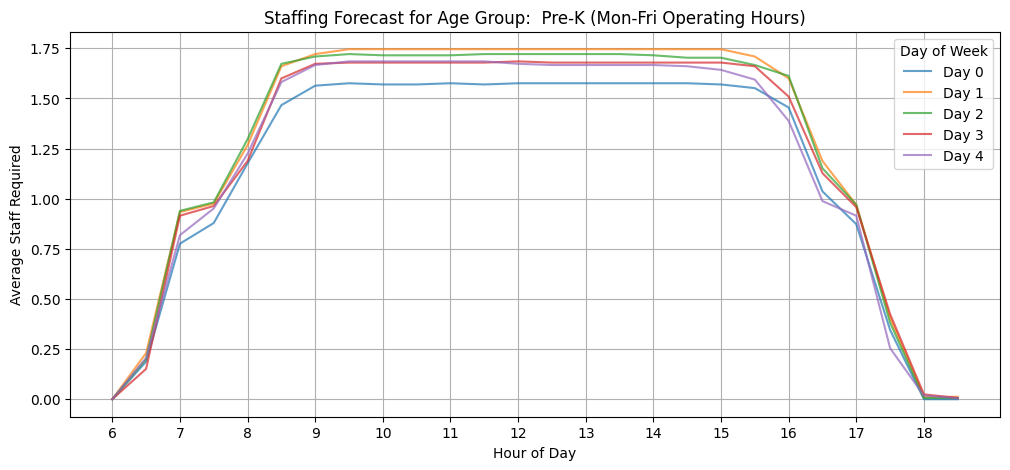

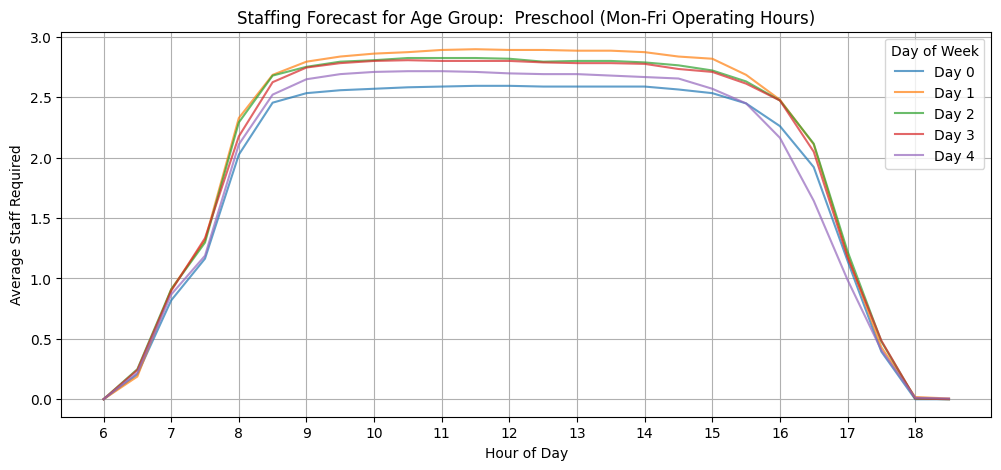

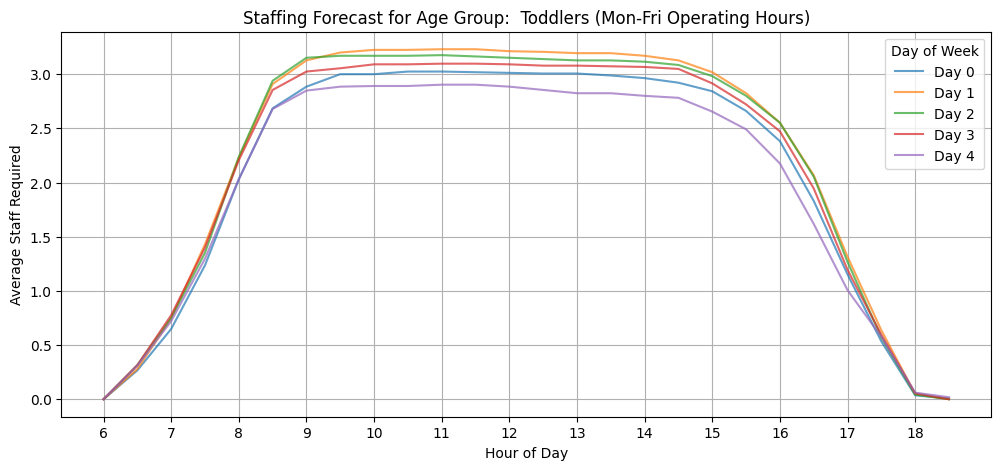

In [21]:
# Define operating hours (6 AM to 6 PM)
OPERATING_HOURS = (6, 18)

# Ensure dataset only includes Monday-Friday & operating hours
typical_week_forecast = df_model.groupby(['dayofweek', 'half_hour_index'] + [col for col in df_model.columns if col.startswith('age_group_')])['staff_required'].mean().reset_index()

typical_week_forecast['hour'] = typical_week_forecast['half_hour_index'] // 2
typical_week_forecast['minute'] = (typical_week_forecast['half_hour_index'] % 2) * 30

typical_week_age_filtered = typical_week_forecast[
    (~typical_week_forecast['dayofweek'].isin([5, 6])) &  # Exclude weekends
    (typical_week_forecast['hour'] >= OPERATING_HOURS[0]) &
    (typical_week_forecast['hour'] <= OPERATING_HOURS[1])
]

# Loop through each age group and create individual plots
age_group_cols = [col for col in typical_week_age_filtered.columns if col.startswith('age_group_')]
for age_group_col in age_group_cols:
    plt.figure(figsize=(12, 5))

    # Filter for the current age group (where the dummy variable is 1)
    subset = typical_week_age_filtered[typical_week_age_filtered[age_group_col] == 1]

    for day in range(5):  # Loop through Monday-Friday
        day_subset = subset[subset['dayofweek'] == day]
        plt.plot(day_subset['hour'] + day_subset['minute'] / 60, day_subset['staff_required'], label=f'Day {day}', alpha=0.7)

    age_group = age_group_col.replace("age_group_", " ") # Extract age group from column name

    plt.title(f"Staffing Forecast for Age Group: {age_group} (Mon-Fri Operating Hours)")
    plt.xlabel("Hour of Day")
    plt.ylabel("Average Staff Required")
    plt.legend(title="Day of Week")
    plt.grid(True)
    plt.xticks(np.arange(OPERATING_HOURS[0], OPERATING_HOURS[1] + 1, 1))

    plt.show()

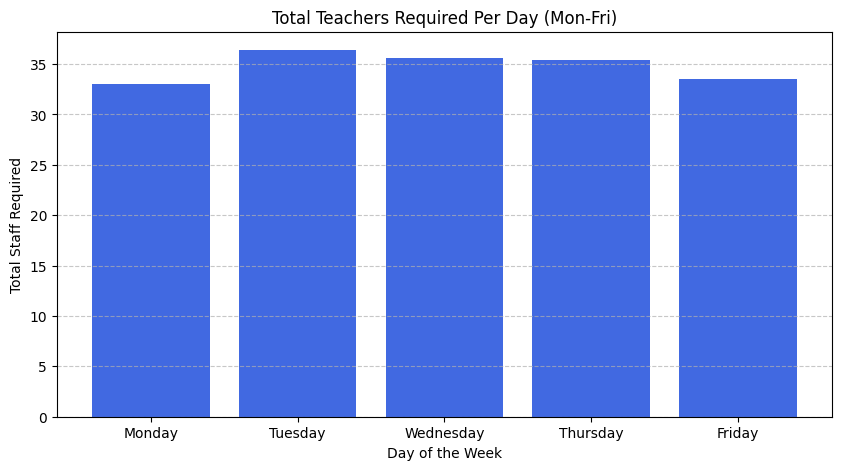

In [15]:
import matplotlib.pyplot as plt

# Ensure we exclude weekends
daily_staffing = typical_week_forecast_filtered.groupby(['dayofweek'])['staff_required'].sum().reset_index()

# Map numeric dayofweek to actual weekday names (Monday-Sunday)
weekday_map = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday"}
daily_staffing['weekday'] = daily_staffing['dayofweek'].map(weekday_map)

# Plot total teachers required per day
plt.figure(figsize=(10, 5))
plt.bar(daily_staffing['weekday'], daily_staffing['staff_required'], color='royalblue')

plt.title("Total Teachers Required Per Day (Mon-Fri)")
plt.xlabel("Day of the Week")
plt.ylabel("Total Staff Required")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()